**1-**
En este paso se carga el archivo *Calificaciones.csv* en un dataframe llamado df utilizando la librería pandas. Después imprime los tipos de datos de cada columna *(df.dtypes)* para identificar cuáles son numéricos y cuáles son categóricos, lo cual es importante para el análisis posterior. Finalmente con *df.head(5)* muestra las primeras 5 filas de la tabla, lo que permite revisar que los datos se hayan importado correctamente y conocer su estructura inicial.

In [18]:
import pandas as pd

df = pd.read_csv("Calificaciones.csv")
print(df.dtypes)
print("\nd",df.head(5))

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object

d   Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10


**2-**
En este paso se crea una copia del dataframe original *(df_mod = df.copy())* para no modificar los datos originales. Luego define en *cat_vars* las variables categóricas (Escuela, Sexo, Internet y HorasDeEstudio) y las transforma en variables dummy con *pd.get_dummies*, usando *drop_first=True* para evitar duplicación de información (colinealidad). Finalmente, con *df_mod.head()* muestra las primeras 5 filas del nuevo dataframe, ya con las variables categóricas convertidas en columnas numéricas listas para usarse en el modelo.

In [37]:
df_mod = df.copy()
cat_vars = ["Escuela", "Sexo", "Internet", "HorasDeEstudio"]
df_mod = pd.get_dummies(df_mod, columns=cat_vars, drop_first=True)
df_mod.head()

,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,HorasDeEstudio_2,HorasDeEstudio_3,HorasDeEstudio_4
0,18,0,6,5,6,6,False,False,False,True,False,False
1,17,0,4,5,5,6,False,False,True,True,False,False
2,15,3,10,7,8,10,False,False,True,True,False,False
3,15,0,2,15,14,15,False,False,True,False,True,False
4,16,0,4,6,10,10,False,False,False,True,False,False


**3-**
Este código identifica valores atípicos en la variable Faltas usando el método de Tukey con k=3. Primero calcula Q1 y Q3, el rango intercuartílico (IQR) y a partir de ahí obtiene los límites inferior y superior. Luego filtra las observaciones que están fuera de esos rangos y las muestra como posibles outliers. Finalmente, se decide eliminar esas observaciones para limpiar la base de datos y evitar que valores extremos distorsionen el modelo.

In [19]:
Q1 = df["Faltas"].quantile(0.25)
Q3 = df["Faltas"].quantile(0.75)
IQR = Q3 - Q1
li = Q1 - 3*IQR
ls = Q3 + 3*IQR

outliers = df[(df["Faltas"] < li) | (df["Faltas"] > ls)]
print("Observaciones atípicas:\n", outliers)
# La decisión fue eliminar outliers
df = df[(df["Faltas"] >= li) & (df["Faltas"] <= ls)]

Observaciones atípicas:
     Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  \
74       GP    F    16               2           0      yes      54  11  12   
183      GP    F    17               2           0      yes      56   9   9   
276      GP    F    18               2           0      yes      75  10   9   
307      GP    M    19               1           1      yes      38   8   9   
315      GP    F    19               3           1      yes      40  13  11   

     G3  
74   11  
183   8  
276   9  
307   8  
315  11  


**4-**
En este paso primero convierte todas las variables categóricas en numéricas con dummies *(pd.get_dummies)* para poder calcular correlaciones. Luego obtiene la matriz de correlación absoluta *(df_num.corr().abs())*, la dibuja como heatmap con matplotlib y se escribe dentro de cada celda el valor numérico de la correlación. Después desglosa toda la matriz para listar los pares más correlacionados, G1 y G2 superan un umbral alto (0.85), se elimina G2 para reducir colinealidad entre predictores (dos variables que dicen casi lo mismo vuelven inestable la regresión y dificultan interpretar los coeficientes). En cambio, G3 no se elimina porque G3 es la variable objetivo (la calificación final que el modelo quiere predecir). La revisión de colinealidad se hace solo entre las variables predictoras (X), quitar G3 dejaría al modelo sin aquello que debe explicar. Por eso se elimina G2 por alta colinealidad con G1.

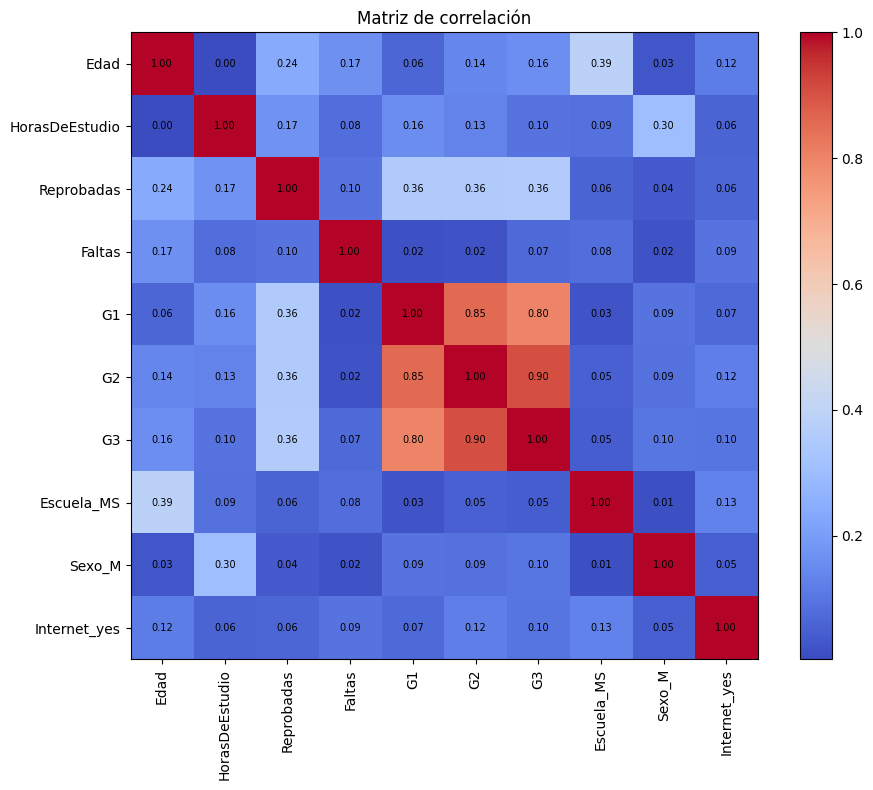

Pares más correlacionados:
 G2  G3    0.904797
G3  G2    0.904797
G1  G2    0.852483
G2  G1    0.852483
G1  G3    0.801391
dtype: float64
Se eliminó G2 por colinealidad alta con G1


In [40]:
import numpy as np
import matplotlib.pyplot as plt

df_num = pd.get_dummies(df, drop_first=True)
cor = df_num.corr().abs()

plt.figure(figsize=(10,8))
plt.imshow(cor, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(cor.columns)), cor.columns, rotation=90)
plt.yticks(range(len(cor.columns)), cor.columns)
for i in range(len(cor.columns)):
    for j in range(len(cor.columns)):
        plt.text(j, i, f"{cor.iloc[i,j]:.2f}", ha="center", va="center", color="black", fontsize=7)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

pairs = cor.unstack().sort_values(ascending=False)
pairs = pairs[pairs < 1] 
print("Pares más correlacionados:\n", pairs.head())
if 'G1' in df_num.columns and 'G2' in df_num.columns:
    if cor.loc['G1','G2'] > 0.85:
        df_num = df_num.drop(columns=['G2'])
        print("Se eliminó G2 por colinealidad alta con G1")

**5-**
En este paso se crean términos de interacción entre la primera calificación (G1) y otras variables. Primero revisa si la columna HorasDeEstudio está en el dataframe como un valor numérico (1 a 4), si existe genera la nueva columna G1_Horas que multiplica G1 × HorasDeEstudio. Si en cambio HorasDeEstudio ya fue transformada a variables dummy (HorasDeEstudio_2, HorasDeEstudio_3, etc.), el código recorre esas columnas y genera nuevas interacciones multiplicando G1 por cada dummy. Además, crea la variable G1_Faltas, que es la multiplicación entre la calificación del primer periodo y el número de faltas. Estas nuevas columnas permiten capturar relaciones más complejas en el modelo, es decir, cómo el efecto de las horas de estudio o de las faltas puede variar dependiendo del desempeño inicial (G1).

In [41]:
if 'HorasDeEstudio' in df_num.columns:  
    df_num['G1_Horas'] = df_num['G1'] * df_num['HorasDeEstudio']
else:
    horas_cols = [c for c in df_num.columns if c.startswith('HorasDeEstudio_')]
    for c in horas_cols:
        new_col = f'G1_{c}'
        df_num[new_col] = df_num['G1'] * df_num[c]

df_num['G1_Faltas'] = df_num['G1'] * df_num['Faltas']
print("Interacciones creadas: G1_Horas y G1_Faltas")
df_num.head()

Interacciones creadas: G1_Horas y G1_Faltas


,Edad,HorasDeEstudio,Reprobadas,Faltas,G1,G3,Escuela_MS,Sexo_M,Internet_yes,G1_Horas,G1_Faltas
0,18,2,0,6,5,6,False,False,False,10,30
1,17,2,0,4,5,6,False,False,True,10,20
2,15,2,3,10,7,10,False,False,True,14,70
3,15,3,0,2,15,15,False,False,True,45,30
4,16,2,0,4,6,10,False,False,False,12,24


**6-**
En este paso el código se entrena y evalúa un modelo de regresión lineal múltiple para predecir la calificación final (G3). Primero separa las variables predictoras (X) de la variable objetivo (y), se divide los datos en entrenamiento (80%) y prueba (20%) y con *statsmodels (sm.OLS)* se genera un resumen estadístico completo del modelo, donde se muestran R^2 ajustado, los coeficientes y la significancia de cada variable. Después con *sklearn* se ajusta otro modelo de regresión lineal, predice las calificaciones finales de los estudiantes en el conjunto de prueba y se calcula dos métricas: R^2 que mide cuánto del resultado explica el modelo y RMSE que indica el error promedio de predicción en la misma escala de G3. Finalmente, la gráfica compara las calificaciones reales (eje X) contra las predicciones (eje Y), cada punto representa un estudiante y la línea roja (Ideal) corresponde a una predicción perfecta. Cuanto más cerca están los puntos de esa línea, mejor es el desempeño del modelo.

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     64.46
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           7.57e-69
Time:                        23:22:31   Log-Likelihood:                -741.53
No. Observations:                 312   AIC:                             1505.
Df Residuals:                     301   BIC:                             1546.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3646      2.809      1.

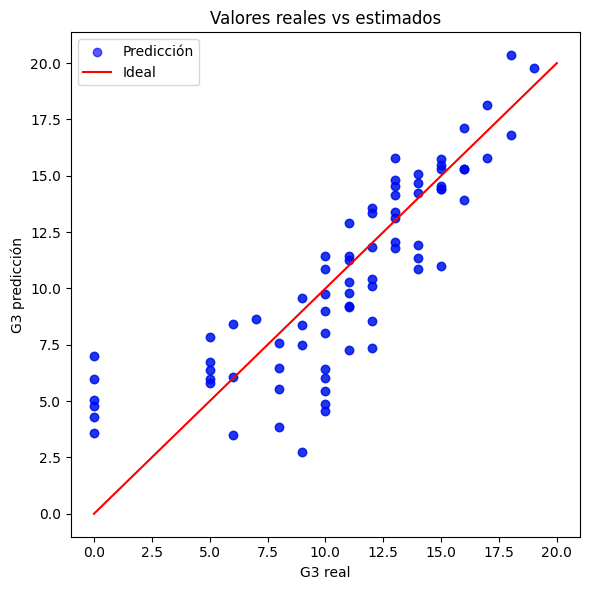

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

X = df_num.drop(columns=['G3'])
y = df_num['G3'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X.astype(float), y, train_size=0.8, random_state=42
)

X_train_sm = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_sm).fit()
print(ols.summary())

modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

r2  = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nR² (test): {r2:.4f}")
print(f"RMSE (test): {rmse:.4f}")


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.scatter(y_test, y_pred, alpha=0.65, color="blue", label="Predicción")
plt.plot([0,20],[0,20], color="r", label="Ideal")
plt.xlabel("G3 real")
plt.ylabel("G3 predicción")
plt.title("Valores reales vs estimados")
plt.legend()
plt.tight_layout()
plt.show()

El modelo de regresión lineal múltiple muestra un buen ajuste general (R^2 ≈ 0.67), lo que significa que explica alrededor del 67% de la variabilidad de la calificación final. El modelo predice bastante bien la calificación final, ya que la mayoría de los puntos están cerca de la línea ideal. Aun así, en algunos casos se equivoca un poco ya que suele dar notas más altas a quienes sacaron bajo y notas más bajas a quienes sacaron muy alto.